In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import time
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
import pytorch_lightning as pl

from src.autoencoder import AutoEncoder
from src.utils import *
from src.rtd import RTDLoss, Rips, RTD_differentiable
from src.top_ae import TopologicallyRegularizedAutoencoder # Bastian Rieck

import umap

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from collections import defaultdict

from tqdm.notebook import tqdm

In [46]:
config = {
    "dataset_name":"Synthetic/Circle",
    "version":"quantile_scaling",
    "model_name":"default",
    "max_epochs":80,
    "gpus":[1],
    "n_neighbors":[5, 20, 100, 400],
    "rtd_every_n_batches":1,
    "rtd_start_epoch":0,
    "rtd_l":3.0, # rtd loss 
    "n_runs":1, # number of runs for each model
    "card":50, # number of points on the persistence diagram
    "n_threads":50, # number of threads for parallel ripser computation of pers homology
    "latent_dim":2, # latent dimension (2 for vizualization purposes)
    "input_dim":2,
    "n_hidden_layers":3,
    "hidden_dim":16,
    "batch_size":80,
#     "width":80,
#     "heigth":80,
    "engine":"giotto",
    "is_sym":True,
    "lr":1e-3
}

In [33]:
def get_model(input_dim, latent_dim=2, n_hidden_layers=2, hidden_dim=32, m_type='encoder'):
    layers = list(
        chain.from_iterable(
            [
                (nn.Linear(hidden_dim, hidden_dim), nn.ReLU()) for _ in range(n_hidden_layers)
            ]
        )
    )
    if m_type == 'encoder':
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()] + layers + [nn.Linear(hidden_dim, latent_dim)]
    elif m_type == 'decoder':
        layers = [nn.Linear(latent_dim, hidden_dim), nn.ReLU()] + layers + [nn.Linear(hidden_dim, input_dim)]
    return nn.Sequential(*layers)

def get_list_of_models(**config):
    # define a list of models
    encoder = get_linear_model(
        m_type='encoder',
        **config
    )
    decoder = get_linear_model(
        m_type='decoder',
        **config
    )
    models = {
#         'Basic AutoEncoder':AutoEncoder(
#            encoder = encoder,
#             decoder = decoder,
#             MSELoss = nn.MSELoss(),
#             **config
#         ),
#         'Topological AutoEncoder':TopologicallyRegularizedAutoencoder(
#             encoder = encoder,
#             decoder = decoder,
#             MSELoss = nn.MSELoss(),
#             **config
#         ),
#         "UMAP":umap.UMAP(n_components=config['latent_dim']),
#         "PCA":PCA(n_components=config['latent_dim']),
# #         "TSNE": TSNE(n_components=config['latent_dim']),
        'RTD AutoEncoder H1':AutoEncoder(
            encoder = encoder,
            decoder = decoder,
            RTDLoss = RTDLoss(dim=1, **config), # only H1
            MSELoss = nn.MSELoss(),
            **config
        ),
#         'RTD AutoEncoder H2':AutoEncoder(
#             encoder = encoder,
#             decoder = decoder,
#             RTDLoss = RTDLoss(dim=2, **config), # only H2
#             MSELoss = nn.MSELoss(),
#             **config
#         )
    }
    return models

In [34]:
def collate_with_matrix(samples):
    indicies, data, labels = zip(*samples)
    data, labels = torch.tensor(np.asarray(data)), torch.tensor(np.asarray(labels))
    if len(data.shape) > 2:
        dist_data = torch.flatten(data, start_dim=1)
    else:
        dist_data = data
    x_dist = torch.cdist(dist_data, dist_data, p=2) / np.sqrt(dist_data.shape[1])
#     x_dist = (x_dist + x_dist.T) / 2.0 # make symmetrical (cdist is prone to computational errors)
    return data, x_dist, labels

In [35]:
dataset_name = config['dataset_name']
train_data = np.load(f'data/{dataset_name}/prepared/train_data.npy').astype(np.float32)

try:
    test_data = np.load(f'data/{dataset_name}/prepared/test_data.npy').astype(np.float32)
except FileNotFoundError:
    ids = np.random.choice(np.arange(len(train_data)), size=int(0.2*len(train_data)), replace=False)
    test_data = train_data[ids]

try:
    train_labels = np.load(f'data/{dataset_name}/prepared/train_labels.npy')
except FileNotFoundError:
    train_labels = None

try:
    test_labels = np.load(f'data/{dataset_name}/prepared/test_labels.npy')
except FileNotFoundError:
    test_labels = None

In [36]:
# scaler = FurthestScaler()
scaler = None
train = FromNumpyDataset(train_data, train_labels, scaler = scaler, flatten=False)
test = FromNumpyDataset(test_data, test_labels, scaler = train.scaler, flatten=False)

train_loader = DataLoader(
    train, 
    batch_size=config["batch_size"], 
    num_workers=2, 
    collate_fn=collate_with_matrix, 
    shuffle=True
)
val_loader = DataLoader(
    test,
    batch_size=config["batch_size"],
    num_workers=2,
    collate_fn=collate_with_matrix,
)

In [37]:
def train_autoencoder(model, train_loader, val_loader=None, model_name='default', 
                      dataset_name='MNIST', gpus=[3], max_epochs=100, run=0, version=""):
    version = f"{dataset_name}_{model_name}_{version}_{run}"
    logger = pl.loggers.TensorBoardLogger(save_dir=os.getcwd(), name='lightning_logs', version=version)
    trainer = pl.Trainer(
        logger=logger, 
        gpus=gpus, 
        max_epochs=max_epochs, 
        log_every_n_steps=10, 
        num_sanity_val_steps=0
    )
    trainer.fit(model, train_loader, val_loader)
    return model

# def validate_knn(train, test, n_neighbors, model_name, accuracies=defaultdict(list)):
#     train_data, train_labels = train
#     test_data, test_labels = test
#     for k in n_neighbors:
#         classifier = KNeighborsClassifier(n_neighbors=k)
#         classifier.fit(train_data, train_labels)
#         pred_labels = classifier.predict(test_data)
#         accuracies[model_name + f"_k{k}"].append(accuracy_score(test_labels, pred_labels))
#     return accuracies

def dump_figures(figures, dataset_name, version):
    for model_name in figures:
        figures[model_name].savefig(f'results/{dataset_name}/{model_name}_{version}.png')

def train_models(train_loader, val_loader, dataset_name="", max_epochs=1, gpus=[], n_neighbors=[1], n_runs=1, version='', **kwargs):
    training_time = defaultdict(list)
    accuracies = defaultdict(list)
    figures = {} # figures for each model run
    trained_models = []
    for run in range(n_runs):
        models = get_list_of_models(**kwargs)
        for model_name in tqdm(models, desc=f"Training models, run: {run+1} out of {n_runs}"):
            start_time = time.time()
            if 'AutoEncoder' in model_name: # train an autoencoder
                    start_time = time.time()
                    models[model_name] = train_autoencoder(
                        models[model_name], 
                        train_loader, 
                        val_loader, 
                        model_name, 
                        dataset_name,
                        gpus,
                        max_epochs,
                        run,
                        version
                    )
                    val_latent, val_labels = get_latent_representations(models[model_name], val_loader)
                    train_latent, train_labels = get_latent_representations(models[model_name], train_loader)
            else: # umap / pca / t-sne (sklearn interface)
                train_latent = models[model_name].fit_transform(train_loader.dataset.data)
                try:
                    val_latent =  models[model_name].transform(test_loader.dataset.data)
                except AttributeError as e:
                    print(model_name)
                    print(e)
                    val_latent = train_latent
            # measure training time
            end_time = time.time()
            training_time[model_name].append(end_time-start_time)
            # Plot latent distributions
            fig, _ = plot_latent(train_latent, train_labels, model_name, dataset_name)
            figures[model_name + f"_{run}"] = fig
            # Calculate knn accuracies and dump them
#             accuracies = validate_knn((train_latent, train_labels), (val_latent, val_labels), n_neighbors, model_name, accuracies)
#             json.dump(accuracies, open(f'results/{dataset_name}/{dataset_name}_{version}_acc.json', 'w'))
            # save trained models
        trained_models.append(models)
    # save figures
    dump_figures(figures, dataset_name, version)
    # save training times
    json.dump(training_time, open(f'results/{dataset_name}/{version}_time.json', 'w'))
    # save accuracies
#     json.dump(accuracies, open(f'results/{dataset_name}/{dataset_name}_{version}_acc.json', 'w'))
    return accuracies, figures, training_time, trained_models

Training models, run: 1 out of 1:   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 898   
1 | decoder | Sequential | 898   
2 | RTDLoss | RTDLoss    | 0     
3 | MSELoss | MSELoss    | 0     
---------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

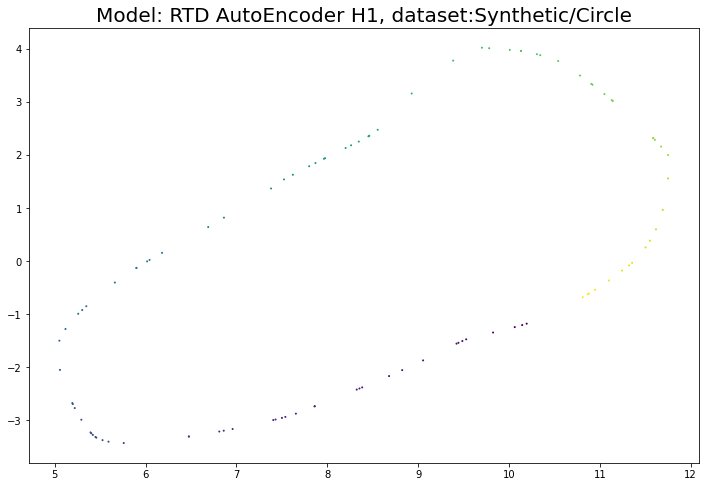

In [47]:
acc, figures, training_time, trained_models = train_models(train_loader, val_loader, **config)

In [40]:
models = trained_models[0]
version = config['version']
train_loader = DataLoader(
    train, 
    batch_size=config["batch_size"], 
    num_workers=2, 
    collate_fn=collate_with_matrix, 
    shuffle=False
)
for model_name in models:
    latent, labels = get_latent_representations(models[model_name], train_loader)
    np.save(f'data/{dataset_name}/{model_name}_output_{version}.npy', latent)
    np.save(f'data/{dataset_name}/{model_name}_labels_{version}.npy', labels)

## Visualization

In [20]:
models = trained_models[0]

In [21]:
from matplotlib.cm import hsv, twilight_shifted
%matplotlib notebook

In [30]:
model_name = 'RTD AutoEncoder H2'
# latent = models[model_name].embedding_
latent, labels = get_latent_representations(models[model_name], train_loader)

In [31]:
labels = train_labels

In [32]:
if labels is None:
    labels = np.ones(latent.shape[0])

<IPython.core.display.Javascript object>


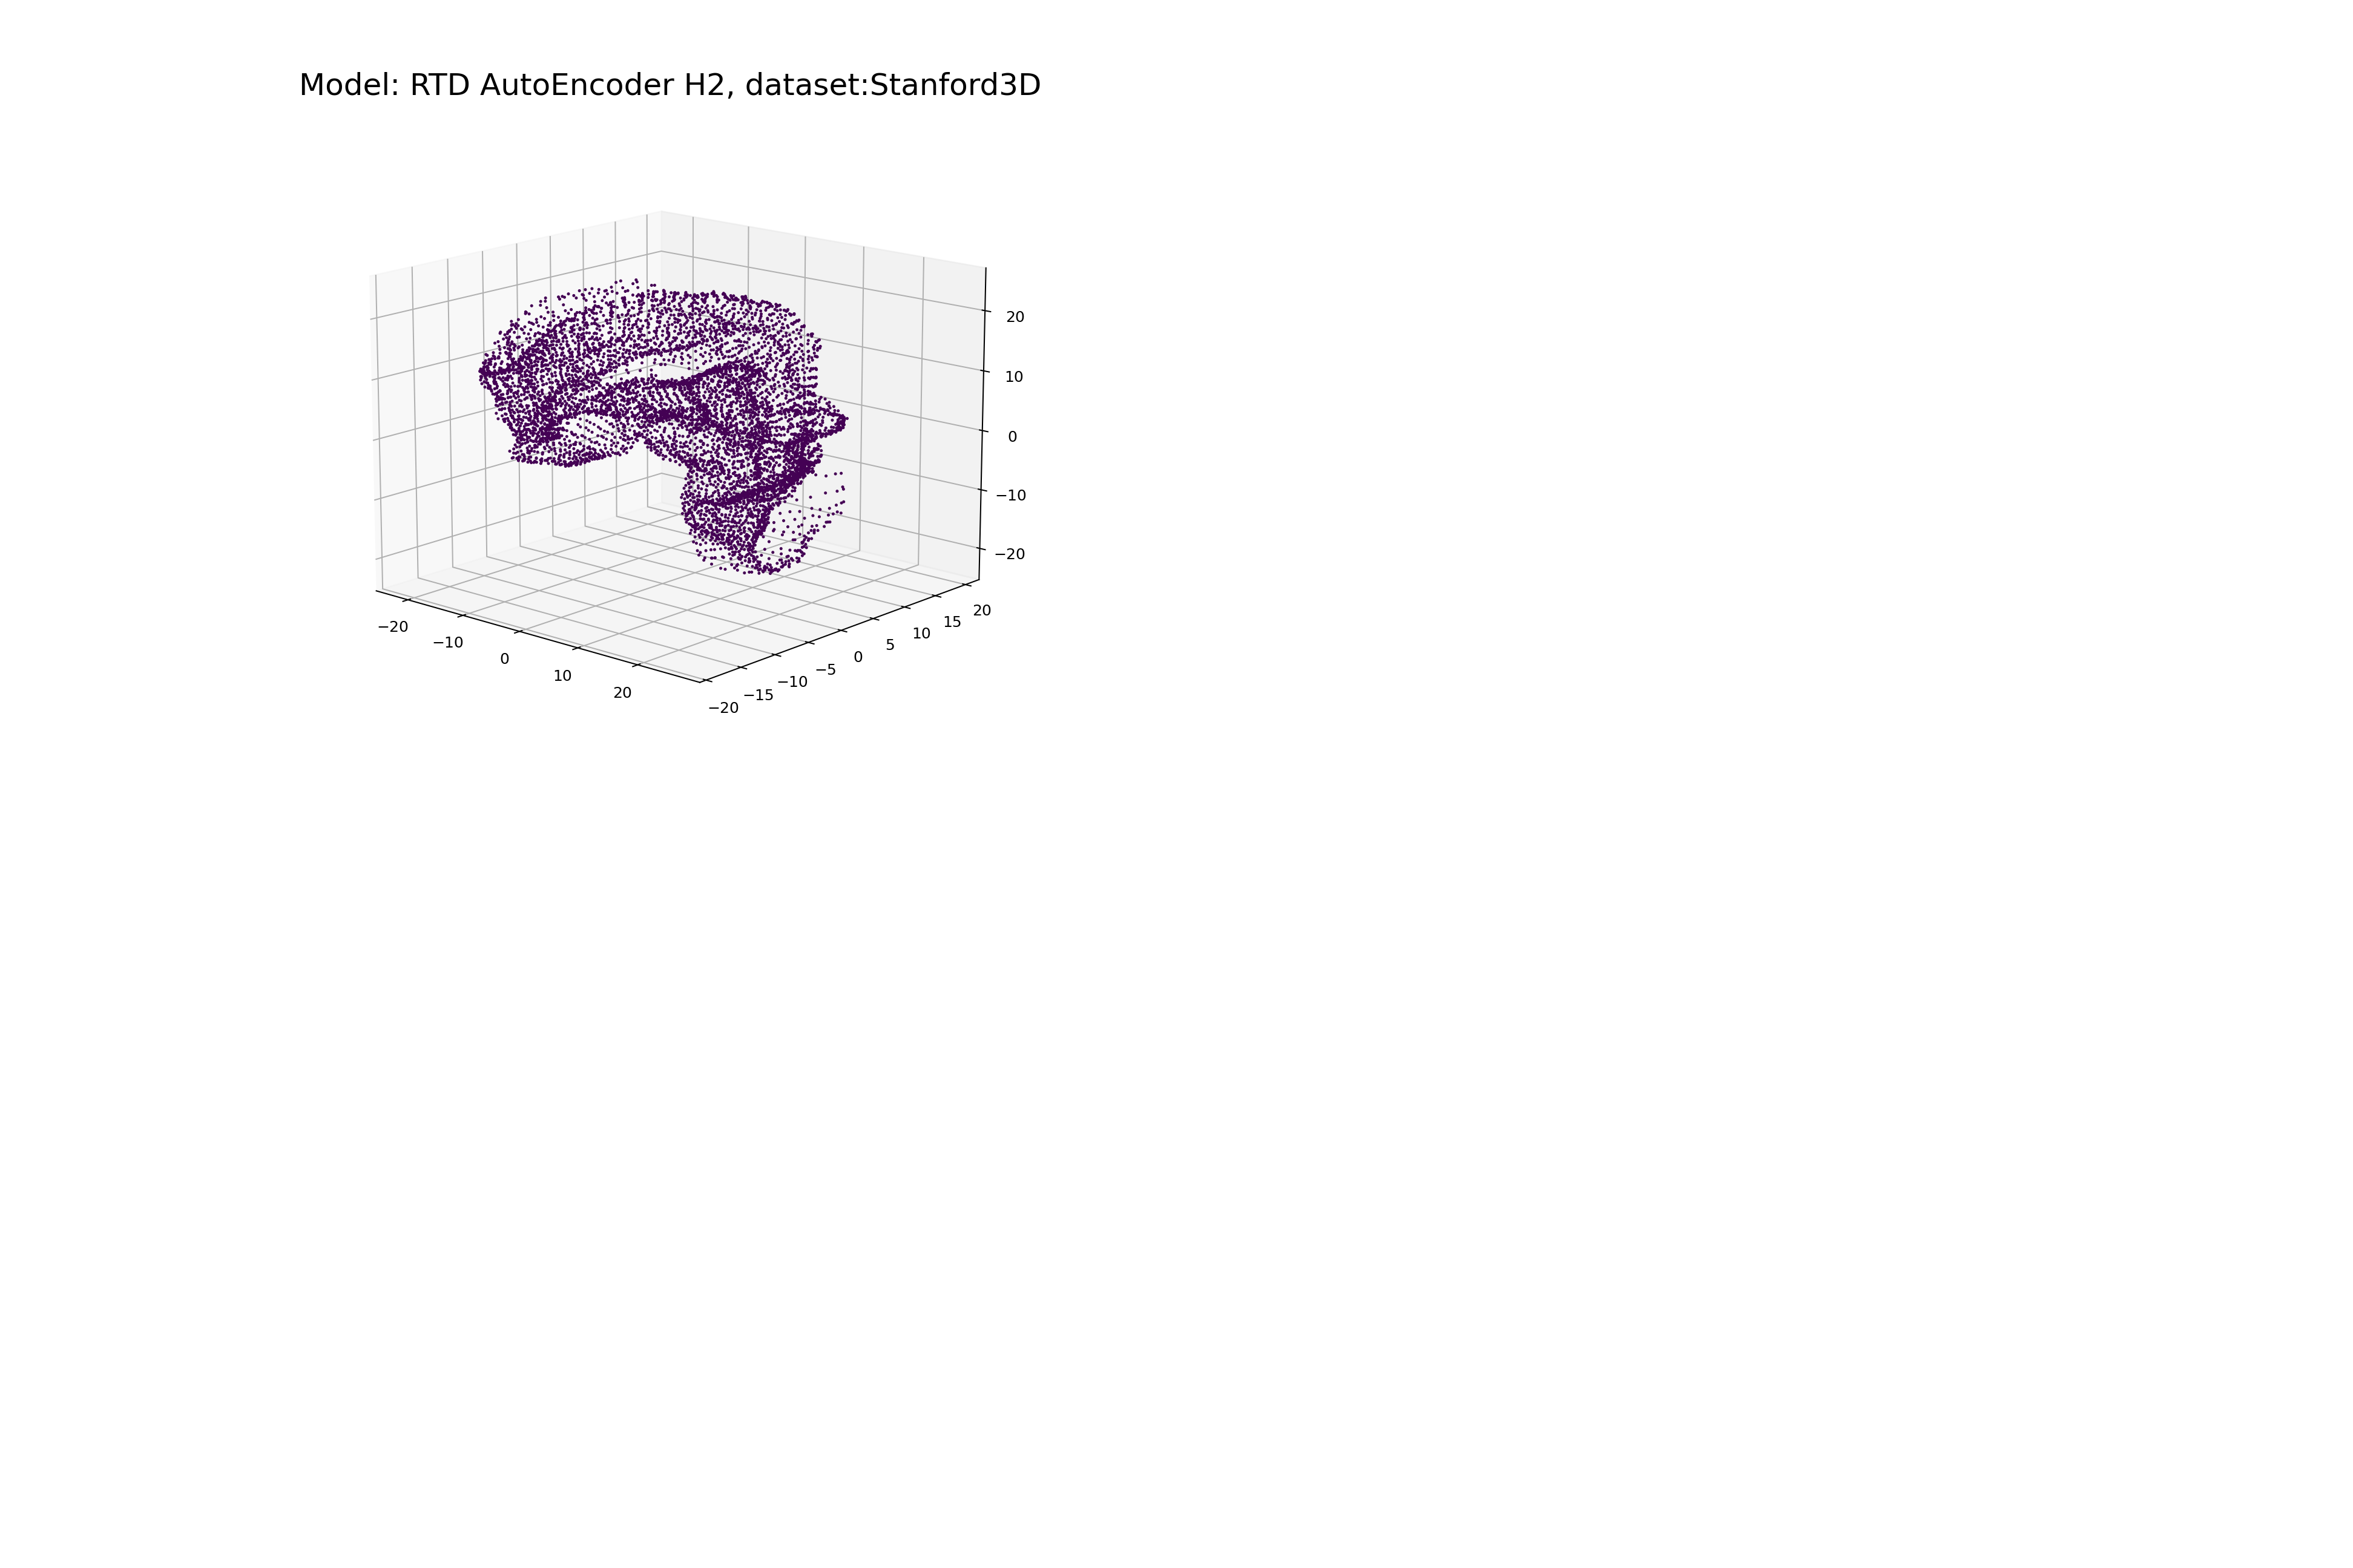

(<Figure size 1200x800 with 1 Axes>,
 <Axes3DSubplot:title={'center':'Model: RTD AutoEncoder H2, dataset:Stanford3D'}>)

In [33]:
plot_latent(latent, labels, model_name = model_name, dataset_name=config['dataset_name'])

In [26]:
orientation_angles = np.load('data/dSprites/prepared/orientation.npy') # from 0 to 2 (in pi's)
place_angles = np.load('data/dSprites/prepared/coordinate.npy')

<IPython.core.display.Javascript object>


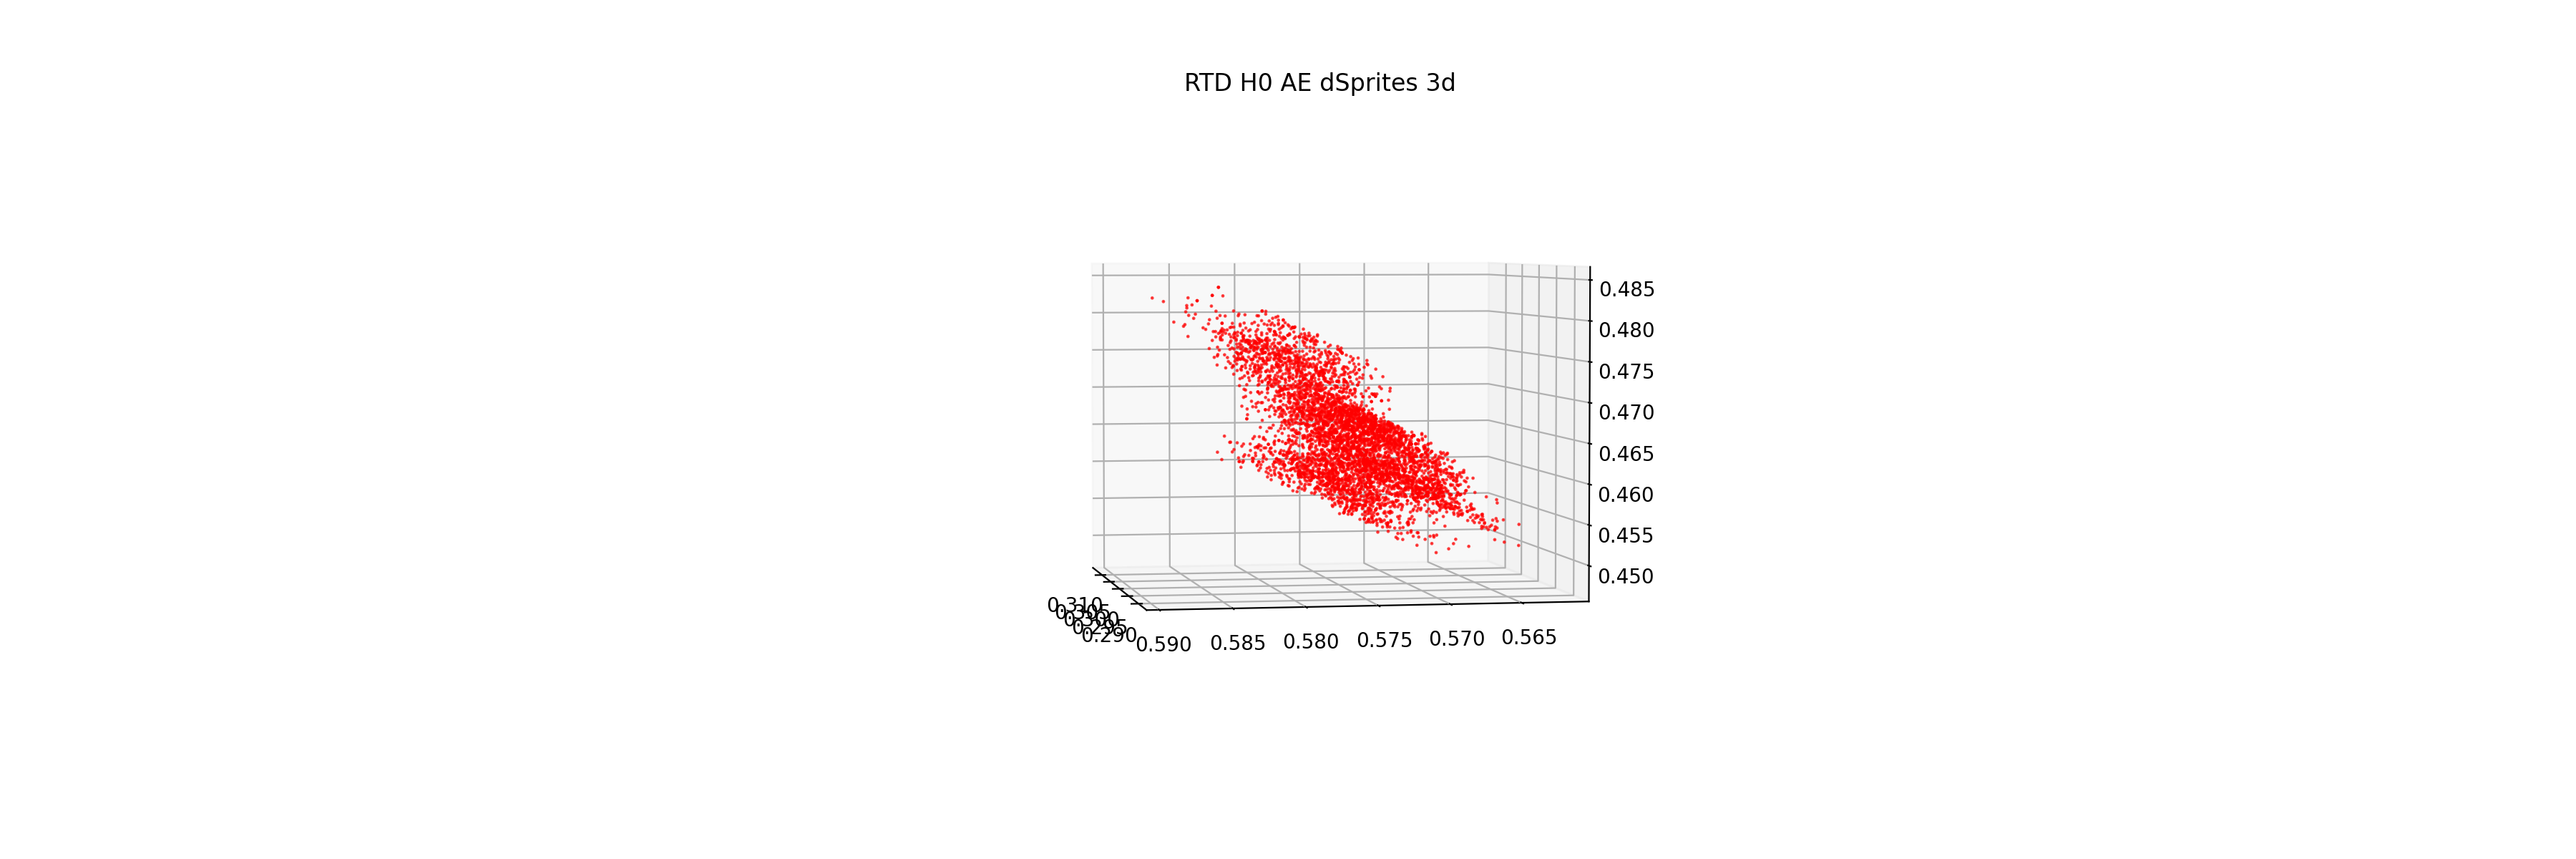

In [27]:
def plot_3d(latent, labels, alpha=0.7, s=0.5, title=""):
    fig = plt.figure(figsize=(18, 6))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter(latent[:, 0], latent[:, 1], latent[:, 2], alpha=alpha, c=labels, s=s, cmap=hsv)
    ax.set_title(title)
    return fig, ax

fig, ax = plot_3d(latent, labels, title="RTD H1 AE dSprites 3d")

In [ ]:
print(rc['pairs'])

In [58]:
def plot_images(imgs, latent, zoom=1.0, n=10):
    """
    Plot data with images
    """
    assert imgs.shape[0] == latent.shape[0], "Latent and images doesn't match"
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    ids = np.random.choice(np.arange(len(latent)), size=n)
    ax.scatter(latent[:, 0], latent[:, 1], alpha=0.7, s=0.5)
    for idx in tqdm(ids, desc="Adding images to plot"):
        im = OffsetImage(imgs[idx], zoom=zoom)
        xy = latent[idx]
        ab = AnnotationBbox(im, xy, xycoords='data', pad=0.)
        ax.add_artist(ab)
    return fig, ax

Adding images to plot:   0%|          | 0/1000 [00:00<?, ?it/s]

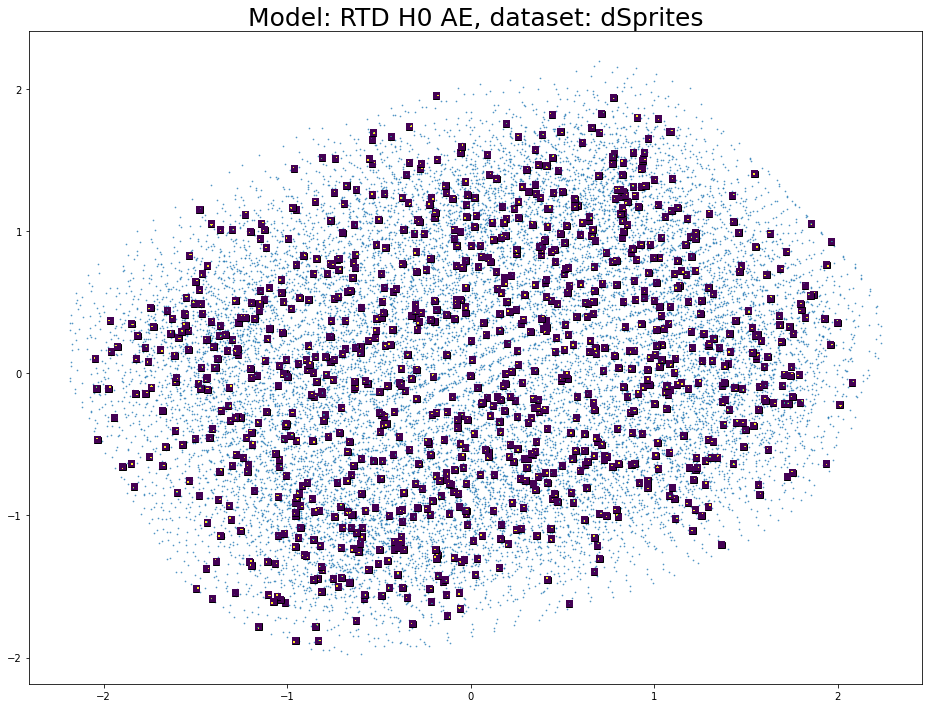

In [61]:
fig, ax = plot_images(train_data, latent, zoom=0.1, n=1000)
ax.set_title("Model: RTD H0 AE, dataset: dSprites", fontsize=25)
plt.show()

In [62]:
fig.savefig('results/dSprites/dSprites_RTD AutoEncoder H0_0_param_scaled_no_orientation_images.png', dpi=2000)

In [63]:
model = umap.UMAP(n_components=2)

In [ ]:
umap_latent = model.fit_transform(train_data.reshape(train_data.shape[0], -1))

In [ ]:
umap_latent

### Scaling constant

In [27]:
trained_models[0]['RTD AutoEncoder H0'].norm_constant

Parameter containing:
tensor([1.0399], requires_grad=True)



#### Scaling parameter:

| Dataset   | Scaled | Value  |
| --------- | ------ | ------ |
| Infty     | True   | 1.3401 |
| Infty     | False  | 1.1144 |
| Spheres   | False  | 3.8995 |
| Spheres   | True   | 1.3766 |

# Robustness to noise study

In [111]:
config = {
    "dataset_name":"Synthetic/3Clusters",
    "version":"",
    "model_name":"default",
    "max_epochs":100,
    "gpus":[1],
    "n_neighbors":[5, 20, 100, 400],
    "rtd_every_n_batches":1,
    "rtd_start_epoch":10,
    "rtd_l":3.0, # rtd loss 
    "n_runs":1, # number of runs for each model
    "card":50, # number of points on the persistence diagram
    "n_threads":50, # number of threads for parallel ripser computation of pers homology
    "latent_dim":2, # latent dimension (2 for vizualization purposes)
    "input_dim":2,
    "n_hidden_layers":3,
    "hidden_dim":32,
    "batch_size":80,
#     "width":80,
#     "heigth":80,
    "engine":"giotto",
    "is_sym":True,
    "lr":1e-2
}

In [10]:
def collate_with_matrix(samples):
    indicies, data, labels = zip(*samples)
    data, labels = torch.tensor(np.asarray(data)), torch.tensor(np.asarray(labels, dtype=np.uint8))
    if len(data.shape) > 2:
        dist_data = torch.flatten(data, start_dim=1)
    else:
        dist_data = data
    x_dist = torch.cdist(dist_data, dist_data, p=2) / np.sqrt(dist_data.shape[1])
#     x_dist = (x_dist + x_dist.T) / 2.0 # make symmetrical (cdist is prone to computational errors)
    return data, x_dist, labels

def get_models(encoder, decoder):
    models = {
        'Basic AutoEncoder':AutoEncoder(
            encoder = encoder,
            decoder = decoder,
            MSELoss = nn.MSELoss(),
            **config
        ),
        'RTD AutoEncoder H1':AutoEncoder(
            encoder = encoder,
            decoder = decoder,
            RTDLoss = RTDLoss(dim=1, **config), # only H1
            MSELoss = nn.MSELoss(),
            **config
        )
    }
    return models

def train_autoencoder(model, train_loader, val_loader=None, model_name='default', 
                      dataset_name='MNIST', gpus=[3], max_epochs=100, run=0, version=""):
    version = f"{dataset_name}_{model_name}_{version}_{run}"
    logger = pl.loggers.TensorBoardLogger(save_dir=os.getcwd(), name='lightning_logs', version=version)
    trainer = pl.Trainer(
        logger=logger, 
        gpus=gpus, 
        max_epochs=max_epochs, 
        log_every_n_steps=10, 
        num_sanity_val_steps=0
    )
    trainer.fit(model, train_loader, train_loader)
    return model

In [11]:
encoder = get_linear_model(
    m_type='encoder',
    **config
)
decoder = get_linear_model(
    m_type='decoder',
    **config
)

In [114]:
# list files with noised data, sort
dataset_name = config["dataset_name"]
dirname = f'data/{dataset_name}/prepared/'
files = []
for filename in os.listdir(dirname):
    if 'noised_data' not in filename:
        continue
    files.append(os.path.join(dirname, filename))
files = list(sorted(files, key = lambda x: int(x.split('_')[-1].split('.npy')[0])))

In [115]:
latents = defaultdict(list)

for filename in tqdm(files, desc='Fitting models on dataset:'):
    data = np.load(filename).astype(np.float32)
    scaler = FurthestScaler()
    train = FromNumpyDataset(data, labels, scaler = scaler, flatten=False)
    train_loader = DataLoader(
        train, 
        batch_size=config["batch_size"], 
        num_workers=2, 
        collate_fn=collate_with_matrix, 
        shuffle=True
    )
    idx = filename.split('_')[-1].split('.npy')[0]
    run = idx
    models = get_models(encoder, decoder)
    for model_name in models:
        models[model_name] = train_autoencoder(
            models[model_name], 
            train_loader, 
            val_loader, 
            model_name, 
            config['dataset_name'],
            config['gpus'],
            config['max_epochs'],
            run,
            config['version']
        )
        latent, labels = get_latent_representations(models[model_name], train_loader)
        latents[model_name].append(latent)

Fitting models on dataset:: 0it [00:00, ?it/s]

In [117]:
def plot_2d(latent, labels, alpha=0.7, s=1.0, title="", fontsize=25, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    scatter = ax.scatter(latent[:, 0], latent[:, 1], alpha=alpha, c=labels, s=s, label=labels)
#     legend = ax.legend(*scatter.legend_elements(num=len(np.unique(labels))), loc="upper left", title="Types")
#     ax.add_artist(legend)
    if len(title):
        ax.set_title(title, fontsize=fontsize)
    return ax

In [121]:
%matplotlib inline

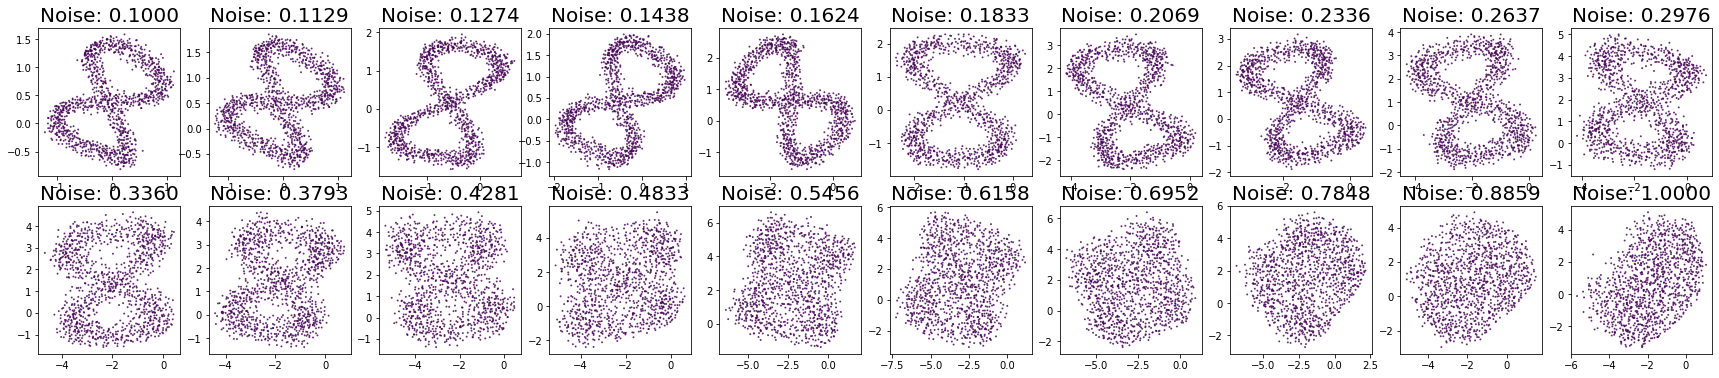

In [124]:
model_name = 'RTD AutoEncoder H1'

noise_scales = np.logspace(-1, 0, 20)
fig, axes = plt.subplots(2, 10, figsize=(30, 6))
axes = axes.ravel()
# fig.suptitle("TSNE vs. Noise scale for Infinity loop", fontsize=25)
for i, noise in enumerate(noise_scales):
    plot_2d(latents[model_name][i], labels, ax=axes[i], title=f'Noise: {noise:.4f}', fontsize=20)
plt.show()

### H1 & H2 & finetune

In [26]:
import copy

In [27]:
latents = defaultdict(list)

In [28]:
# modify autoencoder to employ RTD H1 & H2 policy and etc
class RTD_AutoEncoder(pl.LightningModule):
    def __init__(self, encoder, decoder, RTDLosses=None, MSELoss=None, rtd_l=0.1, rtd_every_n_batches=1, rtd_start_epoch=0, lr=5e-4, **kwargs):
        """
        RTDLoss - function of topological (RTD) loss between the latent representation and the input
        l - parameter of regularization lambda (L = L_reconstruct + \lambda L_RTD)
        """
        super().__init__()
        self.encoder = copy.deepcopy(encoder)
        self.decoder = copy.deepcopy(decoder)
        self.norm_constant = nn.Parameter(data=torch.ones(1), requires_grad=True)
        self.RTDLosses = RTDLosses
        self.MSELoss = MSELoss
        self.rtd_l = rtd_l
#         self.rtd_every_n_batches = rtd_every_n_batches
#         self.rtd_start_epoch = rtd_start_epoch
        self.lr = lr
    
    def forward(self, x):
        embedding = self.encoder(x)
        return embedding
    
    def z_dist(self, z):
        z_dist = torch.cdist(z, z)
#         norm_constant = torch.quantile(z_dist.view(-1), 0.9)
        z_dist = self.norm_constant * (z_dist / np.sqrt(z_dist.shape[1]))
        return z_dist

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, x_dist, y = train_batch
        z = self.encoder(x)  
        x_hat = self.decoder(z)
        loss = 0.0
        # phase 1: train autoencoder with MSE first for 30 epochs
        if self.MSELoss is not None and self.current_epoch < 50:
            loss += self.MSELoss(x_hat, x)
            self.log('train/mse_loss', loss)
        if self.RTDLosses is not None and self.current_epoch >= 5:
            z_dist = self.z_dist(z)
            if self.current_epoch < 50:  # phase 2: train with RTD H1 and MSE for - epochs
                loss_xz, loss_zx, rtd_loss = self.RTDLosses[0](x_dist, z_dist) # H1
            else: # phase 3: train with RTD H1 & H2 for - epochs
                loss_xz, loss_zx, rtd_loss = self.RTDLosses[1](x_dist, z_dist) # H2
            self.log('train/rtd_loss', rtd_loss)
            self.log('train/rtd_loss_xz', loss_xz)
            self.log('train/rtd_loss_zx', loss_zx)
            loss += self.rtd_l*rtd_loss
        self.log('train/loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, x_dist, y = val_batch
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = 0.0
        if self.MSELoss is not None:
            loss += self.MSELoss(x_hat, x)
            self.log('val/mse_loss', loss)
        if self.RTDLosses is not None and self.current_epoch >= 5:
            z_dist = self.z_dist(z)
            if self.current_epoch < 40:
                loss_xz, loss_zx, rtd_loss = self.RTDLosses[0](x_dist, z_dist) # H1
            else:
                loss_xz, loss_zx, rtd_loss = self.RTDLosses[1](x_dist, z_dist) # H1
            self.log('val/rtd_loss', rtd_loss)
            self.log('val/rtd_loss_xz', loss_xz)
            self.log('val/rtd_loss_zx', loss_zx)
            loss += self.rtd_l*rtd_loss
        self.log('val/loss', loss)

In [29]:
# H2 & H1
model_name = 'RTD AutoEncoder H2'
files = [f'data/{dataset_name}/prepared/train_data.npy']
# config['rtd_start_epoch'] = 0

import torch
for filename in tqdm(files, desc='Fitting models on dataset'):
    # load and prepare data
    data = np.load(filename).astype(np.float32)
#     scaler = FurthestScaler()
    scaler = None
    labels = np.ones(data.shape[0])
    train = FromNumpyDataset(data, labels, scaler = scaler, flatten=False)
    
    train_loader = DataLoader(
        train, 
        batch_size=config["batch_size"], 
        num_workers=2, 
        collate_fn=collate_with_matrix, 
        shuffle=True
    )
    idx = filename.split('_')[-1].split('.npy')[0]
    run = idx
    model = RTD_AutoEncoder(
        encoder = encoder,
        decoder = decoder,
        MSELoss = nn.MSELoss(),
        RTDLosses = [RTDLoss(dim=1, **config), RTDLoss(dim=2, **config)],
        **config
    )
    model = train_autoencoder(
        model, 
        train_loader, 
        val_loader, 
        model_name, 
        config['dataset_name'],
        config['gpus'],
        75,
        run,
        config['version']
    )
    latent, labels = get_latent_representations(model, train_loader)
    latents[model_name].append(latent)

Fitting models on dataset:   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 898   
1 | decoder | Sequential | 898   
2 | MSELoss | MSELoss    | 0     
---------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
/workspace/topological_autoencoders/.env/lib/python3.6/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /workspace/topological_autoencoders/lightning_logs/Synthetic/2Clusters_RTD AutoEncoder H2__data/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [30]:
train_loader = DataLoader(
    train, 
    batch_size=config["batch_size"], 
    num_workers=2, 
    collate_fn=collate_with_matrix, 
    shuffle=False
)
latent, labels = get_latent_representations(model, train_loader)

In [31]:
np.save(f'data/{dataset_name}/{model_name}_output.npy', latent)
np.save(f'data/{dataset_name}/{model_name}_labels.npy', labels)

# Vizualisation

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_2d(latent, labels, alpha=0.7, title="", fontsize=25, s=2.0, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    scatter = ax.scatter(latent[:, 0], latent[:, 1], alpha=alpha, c=labels, s=s, label=labels)
#     legend = ax.legend(*scatter.legend_elements(num=len(np.unique(labels))), loc="upper left", title="Types")
#     ax.add_artist(legend)
    if len(title):
        ax.set_title(title, fontsize=fontsize)
    return ax

In [19]:
dataset_name

'Synthetic/2Clusters'

In [36]:
labels = np.load(f'data/{dataset_name}/prepared/train_labels.npy')

In [21]:
ls data/Synthetic/Circle/

'Basic AutoEncoder_labels.npy'   'Topological AutoEncoder_labels.npy'
'Basic AutoEncoder_output.npy'   'Topological AutoEncoder_output.npy'
'RTD AutoEncoder H1_labels.npy'   noised_data.npy
'RTD AutoEncoder H1_output.npy'   prepared/
'RTD AutoEncoder H2_labels.npy'   tsne_output.npy
'RTD AutoEncoder H2_output.npy'   umap_output.npy


In [18]:
model_names = {
    'tsne': "tSNE", 
    'umap':"UMAP", 
    'Basic AutoEncoder':'Autoencoder', 
    'RTD AutoEncoder H1':'RTD H1', 
    'Topological AutoEncoder':'Top AE (Rieck et. al.)', 
    'RTD AutoEncoder H2':'RTD H2'
}

Text(0.5, 0.98, 'Circle')

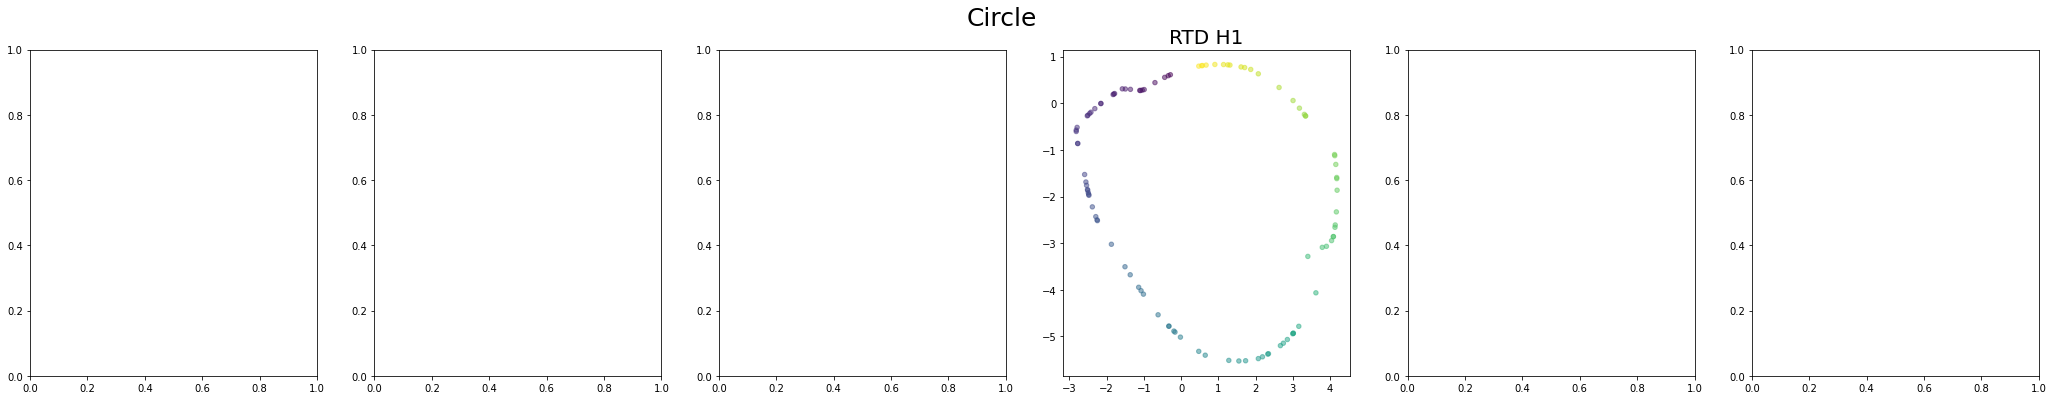

In [41]:
fig, axes = plt.subplots(1, 6, figsize=(36, 6))
for i, model_name in enumerate(model_names):
    try:
        latent = np.load(f'data/{dataset_name}/{model_name}_output_{version}.npy')
    except FileNotFoundError:
        continue
#     try:
#         labels = np.load(f'data/{dataset_name}/{model_name}_labels.npy')
#     except FileNotFoundError:
#         labels = np.load(f'data/{dataset_name}/prepared/train_labels.npy')
    axes[i] = plot_2d(latent, labels, title=model_names[model_name], ax=axes[i], fontsize=20, s=20.0, alpha=0.5)
fig.suptitle("Circle", fontsize=25)

<AxesSubplot:title={'center':'RTD H2'}>

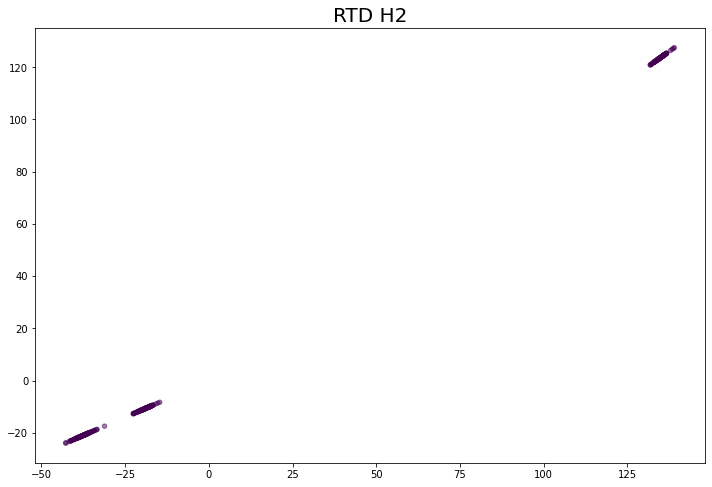

In [155]:
plot_2d(latents['RTD AutoEncoder H2'][0], labels, title='RTD H2', fontsize=20, s=20.0, alpha=0.5)

# Metrics

In [41]:
import json

In [42]:
dataset_name = 'Synthetic/2Clusters'

In [43]:
model_names = [
    'Basic AutoEncoder', 
    'RTD AutoEncoder H1', 
    'RTD AutoEncoder H2', 
    'Topological AutoEncoder', 
    'tsne', 
    'umap'
]

In [44]:
# pearson correlation between distances
from scipy.spatial import distance_matrix
from scipy.stats import pearsonr

def get_distances(data):
    distances = distance_matrix(data, data)
    distances = distances[np.triu(np.ones_like(distances), k=1) > 0]
    return distances

original_distances = get_distances(np.load(f'data/{dataset_name}/prepared/train_data.npy'))
 # take only different 

In [45]:
results = {}
for model_name in model_names:
    try:
        latent_distances = get_distances(np.load(f'data/{dataset_name}/{model_name}_output.npy'))
    except FileNotFoundError:
        continue
    results[model_name] = pearsonr(latent_distances, original_distances)[0]

In [46]:
results

{'Basic AutoEncoder': 0.9247781619016866,
 'RTD AutoEncoder H1': 0.9987607041952116,
 'RTD AutoEncoder H2': 0.9993125627266882,
 'Topological AutoEncoder': 0.7187901378032461,
 'tsne': 0.6331883781658426,
 'umap': 0.5420797764398992}

In [164]:
json.dump(results, open(f'results/{dataset_name}/pearson_dist.json', 'w'))

### Wasserstein

In [95]:
dataset_name = 'Synthetic/2Clusters'

In [96]:
import gudhi as gd
import gudhi.wasserstein as wasserstein
import gudhi.hera as hera

from sklearn.preprocessing import StandardScaler

In [97]:
import ripserplusplus as rpp

In [98]:
def calculate_persistence_gd(distances):
    skeleton = gd.RipsComplex(distance_matrix = distances)
    simplex_tree = skeleton.create_simplex_tree(max_dimension=3)
    barcodes = simplex_tree.persistence()
    pbarcodes = {}
    for i in range(3):
        pbarcodes[i] = [[b[1][0], b[1][1]] for b in barcodes if b[0] == i]
    return pbarcodes

In [99]:
scaler = StandardScaler()

In [100]:
original_data = np.load(f'data/{dataset_name}/prepared/train_data.npy')
original_data = scaler.fit_transform(original_data)
original_distances = distance_matrix(original_data, original_data)

In [101]:
original_barcodes = calculate_persistence_gd(original_distances)

In [102]:
# output = rpp.run('--format distance --dim 2', data = original_distances)
# original_barcodes = output['dgms']

In [103]:
def cast_to_normal_array(barcodes):
    return np.array([[b, d] for b, d in barcodes])

barcodes = {'original':original_barcodes}
data = {'original':original_data}

results = defaultdict(dict)
for model_name in tqdm(model_names, desc="Computing persistent diagrams and wass distance"):
    try:
        latent_data = np.load(f'data/{dataset_name}/{model_name}_output.npy')
        latent_data = scaler.fit_transform(latent_data)
        latent_distances = distance_matrix(latent_data, latent_data)
#         latent_barcodes = rpp.run('--format distance --dim 2', data = latent_distances)['dgms']
        latent_barcodes = calculate_persistence_gd(latent_distances)
        barcodes[model_name] = latent_barcodes
        data[model_name] = latent_data
    except FileNotFoundError:
        continue
    for dim in range(3):
         results[dim][model_name] = hera.wasserstein_distance(
             cast_to_normal_array(original_barcodes[dim]), 
             cast_to_normal_array(latent_barcodes[dim]),
             internal_p=2
         )

Computing persistent diagrams and wass distance:   0%|          | 0/6 [00:00<?, ?it/s]

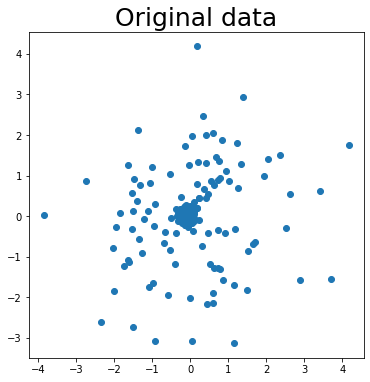

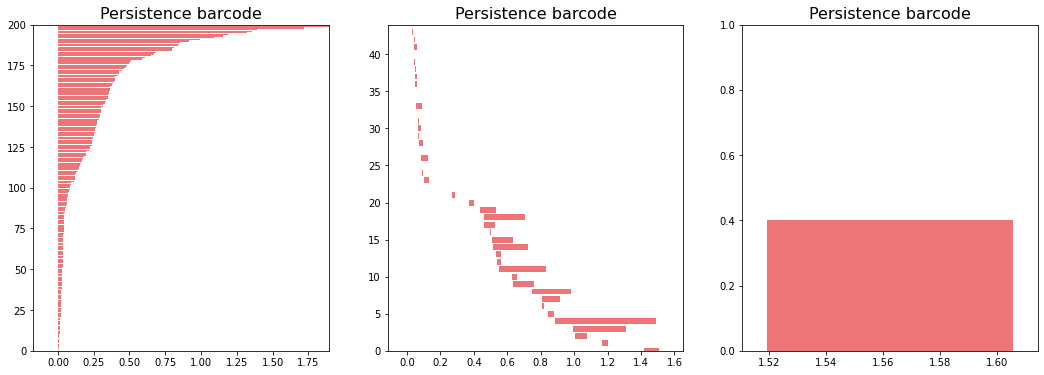

In [104]:
plt.figure(figsize=(6, 6))
plt.scatter(original_data[:, 0], original_data[:, 1])
plt.title("Original data", fontsize=25)
plt.show()
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for dim in barcodes['original']:
    gd.plot_persistence_barcode(barcodes['original'][dim], axes=axes[dim])

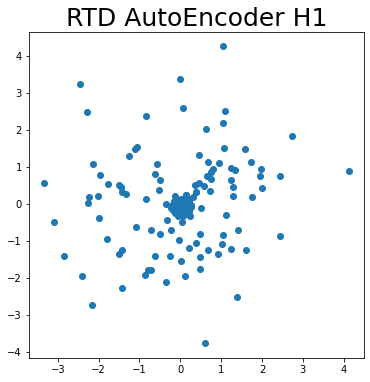

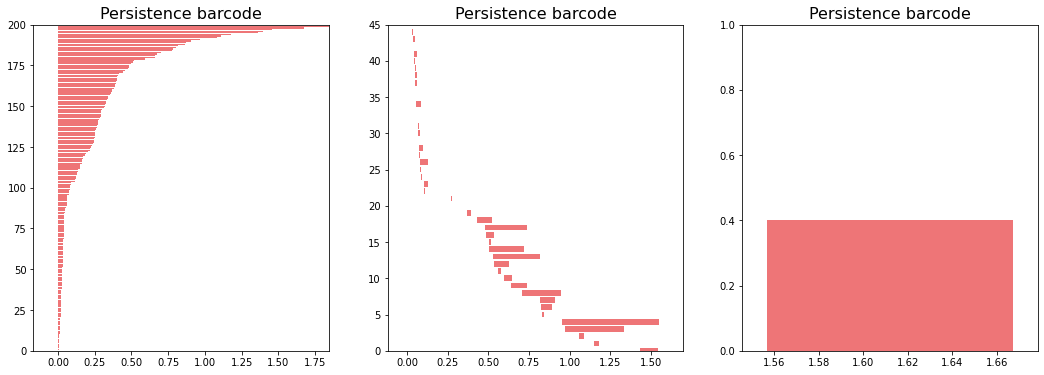

In [105]:
model_name = 'RTD AutoEncoder H1'
plt.figure(figsize=(6, 6))
plt.scatter(data[model_name][:, 0], data[model_name][:, 1])
plt.title(f"{model_name}", fontsize=25)
plt.show()
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for dim in barcodes[model_name]:
    try:
        gd.plot_persistence_barcode(barcodes[model_name][dim], axes=axes[dim])
    except IndexError:
        pass

In [106]:
model_names

{'tsne': 'tSNE',
 'umap': 'UMAP',
 'Basic AutoEncoder': 'Autoencoder',
 'RTD AutoEncoder H1': 'RTD H1',
 'Topological AutoEncoder': 'Top AE (Rieck et. al.)',
 'RTD AutoEncoder H2': 'RTD H2'}

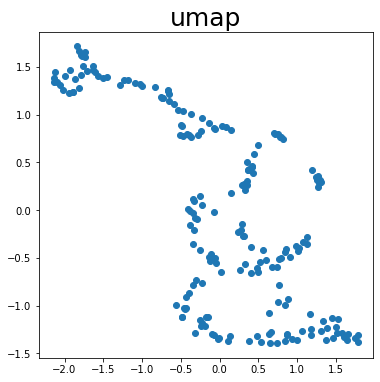

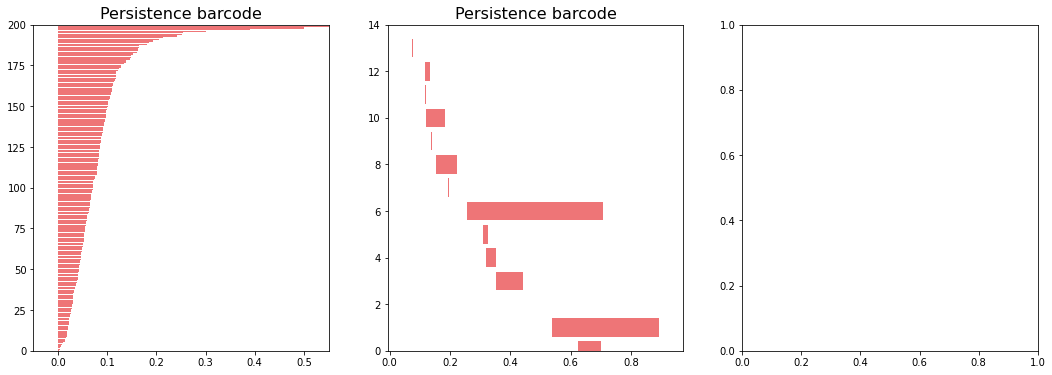

In [107]:
model_name = 'umap'
plt.figure(figsize=(6, 6))
plt.scatter(data[model_name][:, 0], data[model_name][:, 1])
plt.title(f"{model_name}", fontsize=25)
plt.show()
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for dim in barcodes[model_name]:
    try:
        gd.plot_persistence_barcode(barcodes[model_name][dim], axes=axes[dim])
    except IndexError:
        pass

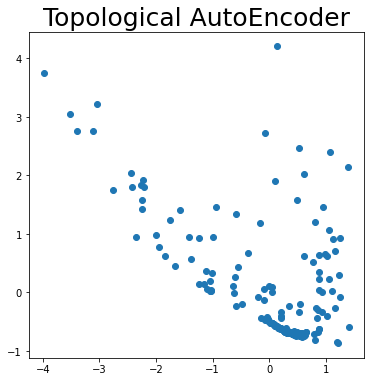

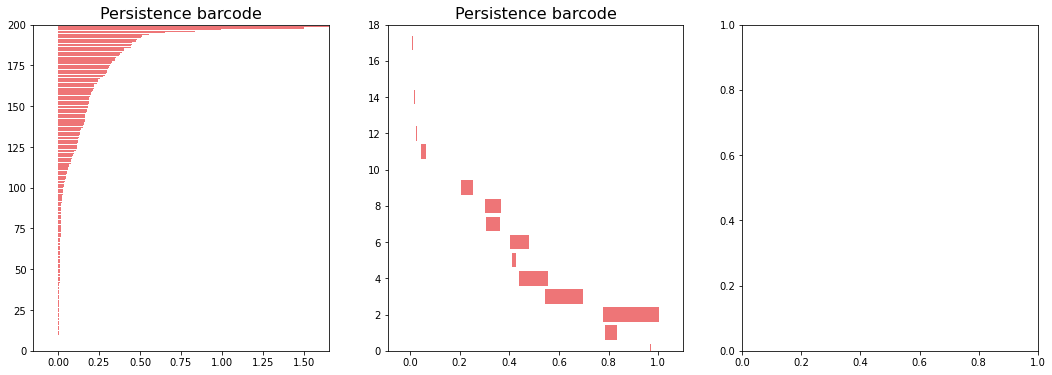

In [108]:
model_name = 'Topological AutoEncoder'
plt.figure(figsize=(6, 6))
plt.scatter(data[model_name][:, 0], data[model_name][:, 1])
plt.title(f"{model_name}", fontsize=25)
plt.show()
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for dim in barcodes[model_name]:
    try:
        gd.plot_persistence_barcode(barcodes[model_name][dim], axes=axes[dim])
    except IndexError:
        pass

In [109]:
import pandas as pd

In [110]:
# p=2
results = pd.DataFrame.from_dict(results).T

In [111]:
results[['umap', 'tsne', 'Basic AutoEncoder', 'Topological AutoEncoder', 'RTD AutoEncoder H1', 'RTD AutoEncoder H2']]

,umap,tsne,Basic AutoEncoder,Topological AutoEncoder,RTD AutoEncoder H1,RTD AutoEncoder H2
0,27.102441,28.872994,5.687320,15.180747,0.872466,1.267652
1,2.140081,2.668204,1.929045,2.017007,0.649105,0.895634
2,0.061104,0.070863,0.096626,0.061104,0.071847,0.061104
